# Link prediction in music collaboration networks

## 1. Introduction

Link prediction is concerned with predicting as-yet unobserved relationships between entities. There are two main types of link prediction task. One is to uncover hidden links which exist in the population but not in the observed data. Another is to predict new links that do not currently exist in the population but form in a future period. For instance, a social networking platform’s friend recommender system could recommend people that a user is likely to already be friends with but has not yet added on the platform (hidden links). Alternatively, it could recommend people that a user does not currently know but is likely to befriend in the near future (new links).

In this paper we assess the extent to which it is possible to predict future collaborations between hip hop artists. This is an instance of the new links type of link prediction task. A sufficiently ‘good’ algorithm could be used by artists to proactively identify other artists with whom they are likely to collaborate in the future and thereby accelerate the collaborative process. 

We will follow a similar methodology to [Hasan et al. (2005)](https://archive.siam.org/meetings/sdm06/workproceed/Link%20Analysis/12.pdf) which is the seminal paper in characterising link prediction as a supervised learning problem. The figure below illustrates our planned approach to constructing training and testing datasets based on a database of hip hop collaborations which we will scrape using the [Discogs API](https://www.discogs.com/developers/).

<img src="https://github.com/nickconvery/link-prediction/raw/master/img/example.png" align="left"></img>

Each pair of artists that did not collaborate with each other between some year, t, and some earlier year, t-w, will be labelled as a positive or negative example depending on whether they went on to collaborate in year t+1. Features that may influence whether a pair of artists went on to collaborate in year t+1 will be extracted from the network formed by collaborations occurring between years t and t-w. For instance, if a pair of artists collaborated with a number of the same artists or if both artists were prolific collaborators then this may increase the likelihood of a future collaboration between the pair. 

A sparse network, where each node is connected to only a small proportion of other nodes, has many potential links and presents challenges in terms of both computation and storage. We therefore plan to follow the recommendation of [Yang et al. (2015)](https://arxiv.org/abs/1505.04094) of dividing the link prediction task into subproblems based on the distance of potential links. In other words, we will consider pairs of artists separated by two hops separately from pairs of artists separated by three hops, and so on.

In summary, our objectives in this analysis are to:

1.	assess the extent to which it is possible to outperform a baseline random predictor in predicting future collaborations between hip hop artists using logistic regression and decision tree classifiers, as assessed using Receiver Operator Characteristic (ROC) and precision-recall curves (accuracy will be an inappropriate metric due to extreme class imbalance).

2.	assess the impact of the duration of the ‘feature window’ (w in the figure above) on classifier performance. Our intuition is that classifier performance may at first increase due to increased information but perhaps eventually begin to decrease due to noise. This will be assessed using ROC as class imbalance increases with the feature window and ROC (unlike precision) is not sensitive to class imbalance.

## 2. Scrape data

We will be using data from the online community-built music database [Discogs.com](http://www.discogs.com). We investigated several potential data sources (e.g. Spotify, MusicBrainz) and found Discogs to be the most comprehensive in terms of listing other artists in track credits, as well as having other advantages discussed below.

We first import the libraries we will need to perform our analysis. We also define two functions *save_obj* and *load_obj* which we will use to save and load objects generated during this notebook that take considerable time to compute.

In [1]:
# general
import time, pickle, re, os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
sns.set_style('darkgrid')

# scraping data
import discogs_client
from bs4 import BeautifulSoup
from OpenSSL.SSL import SysCallError
from requests.exceptions import SSLError
from requests.adapters import ConnectionError
from discogs_client.client import HTTPError

# processing data
import networkx as nx
import itertools
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index

# analysing data
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import ParameterGrid

In [2]:
def save_obj(obj, name):
    with open(str(name) + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [3]:
def load_obj(name):
    with open(str(name) + '.pkl', 'rb') as f:
        return pickle.load(f)

### 2.1 Scrape all hip hop tracks released between 2006 and 2017

We have selected 2016 and 2017 as the years for which we will be predicting collaborations in the training and testing datasets respectively. We have decided to investigate feature windows of up to 10 years, so we will need to scrape data for all hip hop tracks released between 2006 and 2017.

We will be using the [Official Python Client](https://github.com/discogs/discogs_client) for the [Discogs API](https://www.discogs.com/developers/). We have defined the following functions:

- *get_releases* queries the Discogs API for all releases in a given year, genre and country.

- *get_countries* scrapes a local copy of a webpage showing all values the country field can take on Discogs (local copy required to bypass sign-in). We need to filter by country in addition to year as there are 15,000+ hip hop releases per year and the API returns a maximum of 10,000 releases per query.

- *scrape_release* extracts various details for every track in a release (a 'release' object in the Discogs database represents an album, EP or single which may have multiple tracks)

The final code block in this subsection uses these functions to scrape all hip hop tracks listed on Discogs released between 2006 and 2018 (our analysis period is 2006 to 2017; as this work is being carried out in late-2018 we will also scrape the partial data available for 2018 for potential future study).

In [4]:
USER_TOKEN =  '' ### PRIVATE API KEY REDACTED
d = discogs_client.Client('HipHopScraper/0.1', user_token=USER_TOKEN)

In [5]:
def get_releases(discogs_client, year, genre, country):
    return discogs_client.search('', genre=genre, type='release', year=year, country=country)

In [6]:
def get_countries():
    page = BeautifulSoup(open('countries.html'), 'lxml') #local copy as requires log-in
    country_spans = page.find_all(name = 'span', attrs = {'class': 'filterlink'})
    countries = [c.text.split('(')[0].rstrip() for c in country_spans]
    return countries[:-8] #picks up a few other links on page that aren't countries

In [7]:
def scrape_release(release):
    
    # note: API quirk
    ### need to access release.tracklist first as this populates release.data with detailed tracklist info 
    tracklist = release.tracklist
    data = release.data
    artists_main = [a for a in release.artists]
    
    if data['master_id'] != 0:
        time.sleep(0.5)
        main_release_id = release.master.main_release.id
    else:
        main_release_id = ''
        
    release_tracks = list()
    
    for tr in data['tracklist']:
                 
        if 'extraartists' in tr:
            artists_other = [[f['id'], f['name'], f['role']] for f in tr['extraartists']] 
        else:
            artists_other = []     

        track = dict()
        track['title'] = tr['title']
        track['artists_main'] = artists_main
        track['artists_other'] = artists_other
        track['year'] = data['year']
        track['style'] = data['style'] 
        track['release'] = data['title']
        track['release_id'] = data['id']
        track['main_release_id'] = main_release_id
        
        release_tracks.append(track)
        
    time.sleep(0.5)
        
    return release_tracks

In [ ]:
years = [year for year in range (2006, 2019)]
countries = get_countries()

all_releases = [get_releases(d, year=y, country=c, genre='Hip Hop') for y in years for c in countries]
    
total = 0
for releases in all_releases:
    while True:
        try:
            total += releases.count
            time.sleep(0.5)
            break
        except ConnectionError:
            print('ConnectionError')
            continue

start=time.time()
scraped = 0
print('Scraping', total, 'releases')

all_tracks = list()
    
for releases in all_releases:
    for release in releases:
            
        if (scraped+1) % 100 == 0:
            print('Scraping', scraped+1, 'of', total, 'releases.', 
                  int(100*(scraped+1)/total), '% complete.', 
                  'Time elapsed:', int(time.time() - start), 'seconds.')

        while True:
            try:
                release_tracks = scrape_release(release)
                
            except (SSLError, SysCallError, HTTPError, ConnectionError):
                print('Error - will try to scrape release again.')
                continue
                
            all_tracks += release_tracks
            scraped += 1
            break
            
save_obj(all_tracks, 'tracks_2006to2018')
print('Finished scraping all releases')

### 2.2 Get unique tracks

In [8]:
all_tracks = load_obj('tracks_2006to2018')

We now have a list of 2,812,737 individual tracks. Below is an example item from the list.

In [9]:
len(all_tracks)

2812737

In [10]:
all_tracks[200]

{'title': "Breakin' Up",
 'artists_main': [<Artist 36158 'Gwen Stefani'>],
 'artists_other': [[395544, 'Alex Dromgoole', 'Engineer [Assistant]'],
  [395543, 'David Emery', 'Engineer [Assistant]'],
  [509037, 'Hart Gunther', 'Engineer [Assistant]'],
  [211449, 'Mark Stent', 'Mixed By'],
  [17110, 'The Neptunes', 'Producer'],
  [177094, 'Brian Garten', 'Recorded By'],
  [36158, 'Gwen Stefani', 'Written-By'],
  [90037, 'Pharrell Williams', 'Written-By']],
 'year': 2006,
 'style': ['RnB/Swing', 'Europop'],
 'release': 'The Sweet Escape',
 'release_id': 4075300,
 'main_release_id': 976023}

In the Discogs database a single album or EP is sometimes represented by a number of releases, such as an American and European release. Our list will therefore have duplicate entries where the same track appears on multiple releases. We want to avoid double-counting tracks as we will later construct a weighted graph where edge weights represent the number of collaborations between two artists.

Fortunately, Discogs assigns a main release identifier to a group of related releases (e.g. for a given album, the US release may be listed as the main release). We define a function *get_unique_tracks* below which first extracts all tracks from main releases, and then only adds tracks from related releases where that track name does not appear on the main release (this will capture, for instance, bonus tracks or B-sides not included on the main release). This reduces the number of tracks from 2,812,737 to 2,398,551. 

In [11]:
def get_unique_tracks(tracks):
    
    main_releases = {tr['main_release_id']: [] for tr in tracks}
    main_release_tracks = [tr for tr in tracks if tr['release_id'] == tr['main_release_id'] or tr['main_release_id'] == '']

    for tr in main_release_tracks:
        if tr['main_release_id'] != '':
            main_releases[tr['main_release_id']].append(tr['title'].lower())
            
    non_main_release_tracks = [tr for tr in tracks if tr['release_id'] != tr['main_release_id'] and tr['main_release_id'] != '']
    
    additional_tracks = list()
    for tr in non_main_release_tracks: 
        if tr['title'].lower() not in main_releases[tr['main_release_id']]:
            additional_tracks.append(tr)
            
    return main_release_tracks + additional_tracks

In [12]:
tracks = get_unique_tracks(all_tracks)
save_obj(tracks, 'tracks_2006to2018_unique')
len(tracks)

2398551

### 2.3 Get aliases and members

In the Discogs database each artist can be easily linked to their aliases (e.g. releases as Notorious B.I.G and as Biggie Smalls) or to its members if the artist is a group (e.g. Wu-Tang Clan). When constructing a graph of collaborations this information will allow us to:
- Represent each individual artist as a single node (i.e. not consider future collaborations of an artist with themselves)
- Represent tracks released by groups as collaborations between the individual group members

*get_aliases_members* takes a list of tracks as input and queries the Discogs API to generate two dictionaries which are lookups from each artist identifier in the list to: any aliases for that artist, and any members for that artist (if the artist is a group). 

We are concerned with vocal collaborations between hip hop artists and so will exclude artists that only have credits such as production, engineering, and mixing. We use the following regex which captures credits where featuring, vocal or rap begin a word, but not where this word appears in square brackets (this excludes, for instance, *'Recorded by [artist x's vocals]'*).

In [13]:
VOCAL_CREDIT = r'(\bfeaturing|\bvocal|\brap)(?![^\[]*\])'

In [14]:
credits = [a[2] for tr in tracks for a in tr['artists_other']]
print('Number of credit variations:', len(set(credits)))
print('For example, top 30 most frequent are:')
Counter(credits).most_common()[:30]

Number of credit variations: 22557
For example, top 30 most frequent are:


[('Featuring', 489227),
 ('Producer', 298885),
 ('Written-By', 275296),
 ('Remix', 63956),
 ('Lyrics By', 42432),
 ('Music By', 34194),
 ('Mixed By', 34145),
 ('Vocals', 26002),
 ('Recorded By', 24156),
 ('Rap [Featuring]', 23629),
 ('Scratches', 16861),
 ('Backing Vocals', 16345),
 ('Rap', 15678),
 ('Guitar', 14177),
 ('Co-producer', 12229),
 ('Composed By', 10507),
 ('Written By', 9958),
 ('Vocals [Additional]', 9792),
 ('Engineer', 9254),
 ('Bass', 8923),
 ('Keyboards', 7609),
 ('Drums', 6435),
 ('Violin', 6378),
 ('Arranged By', 5974),
 ('Performer', 5825),
 ('Engineer [Assistant]', 5125),
 ('Mastered By', 4605),
 ('Songwriter', 4585),
 ('Music By, Lyrics By', 4355),
 ('Scratches [Cuts]', 4300)]

In [15]:
def get_aliases_members(tracks, vocal_credit):
    
    aliases = dict()
    members=dict()

    start=time.time()

    for i, tr in enumerate(tracks):

        if (i + 1) % 100 == 0: 
            print('Getting artists from track', i+1, 'of', len(tracks),
                 int(100*(i+1)/len(tracks)), '% complete.',
                 'Time elapsed:', int(time.time()-start), 'seconds.')

        artists_main = [a for a in tr['artists_main'] if a.id != 194 and a.id not in aliases]
        artists_other = [d.artist(a[0]) for a in tr['artists_other'] if a[0] != 194 and a[0] not in aliases and re.search(vocal_credit, a[2].lower())]
        track_artists = artists_main + artists_other

        for a in track_artists:
            while True:
                try:
                    time.sleep(0.5)
                    aliases.update({a.id: [alias.id for alias in a.aliases]})
                    aliases.update({alias: [a] + aliases[a] for alias in aliases[a] if alias not in aliases})
                    time.sleep(0.5)
                    members.update({a.id: [member.id for member in a.members]})
                    break
                except HTTPError as e:
                    if str(e) == '404: Artist not found.':
                        print('HTTPError: 404 Artist not found. Skipping.', a.id)
                        break
                    else:
                        print('HTTPError: other. Trying again.', a.id)
                        continue
                except (SSLError, SysCallError, ConnectionError):
                    print('Error. Trying again.', a.id)
                    continue
                    
    return aliases, members

In [ ]:
aliases, members = get_aliases_members(tracks, VOCAL_CREDIT)
save_obj(aliases, 'aliases')
save_obj(members, 'members')

## 3. Process data

In [16]:
def make_graph(tracks, start, end, vocal_credit, aliases, members):
    
    g = nx.Graph()
    
    for tr in tracks:
        
        if start <= tr['year'] <= end:
    
            artists_main = [a.id for a in tr['artists_main'] if a.id in aliases]
            artists_other = [a[0] for a in tr['artists_other'] if a[0] in aliases and re.search(vocal_credit, a[2].lower())]

            track_artists = list()
            for a in artists_main + artists_other:
                if len(members.get(a, [])) == 0:
                    track_artists.append(min([a] + aliases[a]))
                else:
                    members_new = [min([m] + aliases.get(m, [np.inf])) for m in members[a]]
                    track_artists += members_new

            g.add_nodes_from(track_artists)
            
            combos = list(itertools.combinations(track_artists, 2))
            for c in combos:
                if g.has_edge(c[0], c[1]):
                    g[c[0]][c[1]]['weight'] += 1
                    
                else:
                    g.add_edge(c[0], c[1], weight=1)
            
    print('Graph created with', g.number_of_nodes(), 'nodes and', g.number_of_edges(), 'edges.')
    
    return g

### 3.1 Create graphs

We define a function *make_graph* which takes as an input a list of tracks, a start year, an end year, and lookups of artists to aliases and members and creates a weighted undirected graph where edge weights represent the number of collaborations between two artists over a period.

For the training dataset, we will be predicting collaborations in 2016. We will therefore create a graph spanning back *w* years from 2016 where *w* is the feature window (we investigate feature windows of up to 10 years). Features will be extracted from the subgraph which ignores edges formed in 2016 (as these are the edges we will be trying to predict). The testing dataset will be constructed in a similar way as shown below.

<img src="https://github.com/nickconvery/link-prediction/raw/master/img/example.png" align="left"></img>

In [17]:
def graph_summary_by_feat_window(tracks, end_year, feat_windows, dist, vocal_credit, aliases, members):
    
    current = 0
    start=time.time()

    for w in feat_windows:

        g_feat = make_graph(TRACKS, end_year-w, end_year-LABEL_WINDOW, vocal_credit, aliases, members)
        g_label = make_graph(TRACKS, end_year-w, end_year, vocal_credit, aliases, members)

        summary = dict()
        summary['nodes'] = g_feat.number_of_nodes()
        summary['edges'] = g_feat.number_of_edges()
        summary['non_edges'] = comb(summary['nodes'], 2) - summary['edges']
        summary.update({'dist_' + str(k): 0 for k in range(1,dist+1)})
        summary.update({'links_' + str(k): 0 for k in range(1,dist+1)})
        visited = set()

        for node_a, node_a_dict in nx.all_pairs_shortest_path_length(g_feat, cutoff=dist):
            visited.add(node_a)

            for node_b, path_length in node_a_dict.items():
                if node_b not in visited:

                    summary['dist_' + str(path_length)] += 1 
                    summary['links_' + str(path_length)] += g_label.has_edge(node_a, node_b)
                    current+=1   

                    if current % 100000 == 0:
                        print(current, time.time() - start, summary)

        save_obj(summary, '2016_fw_' + str(w) + '_summary')

The table below summarises the number of nodes, edges and non-edges by feature window (using *graph_summary_by_feat_window* and *make_graph*).

In [ ]:
ALIASES = load_obj('aliases')
MEMBERS = load_obj('members')
TRACKS = load_obj('tracks_2006to2018_unique')
LABEL_WINDOW = 1
FEAT_WINDOWS = [1,2,3,4,5,6,7,8,9,10]

graph_summary_by_feat_window(TRACKS, 2016, FEAT_WINDOWS, 6, VOCAL_CREDIT, ALIASES, MEMBERS)

In [18]:
summary = [load_obj('2016_fw_{0}_summary'.format(i)) for i in range(1,11)]
df = pd.concat([pd.DataFrame(summary[i], index=[i+1]) for i, s in enumerate(summary)])
df.index.name = 'Feature window (years)'
df[['nodes', 'edges', 'non_edges']]

,nodes,edges,non_edges
Feature window (years),,,
1,26068,74205,"339,683,073.00"
2,44572,158857,"993,150,449.00"
3,59729,222165,"1,783,524,691.00"
4,73373,282985,"2,691,478,893.00"
5,86988,348975,"3,783,063,603.00"
6,98448,412516,"4,845,542,612.00"
7,109576,472911,"6,002,922,189.00"
8,120642,527980,"7,276,657,781.00"
9,131643,600663,"8,664,273,240.00"


Non-edges represent pairs of artists who did not collaborate during the feature window. The number of potential links to predict for even the shortest window (394 million) presents computational challenges in terms of both processing and storage. 

A common approach in link prediction has been to employ training and test set sampling. However, Yang et al. (2015) show that test set sampling can lead to highly variable evaluation results when dealing with extreme class imbalance as is the case for most link prediction tasks, which affects the ability to make valid inferences about the relative performance of different link prediction algorithms. 

Yang et al. (2015) instead recommend breaking the link prediction task into subproblems based on the distance of potential links (i.e. the shortest path between the two nodes) and considering all potential links at that distance. We therefore follow this approach which the authors argue has the following advantages:

1. Reduces computational burden without compromising evaluation and comparison between algorithms
2. Provides a more sober view of performance by not including in the evaluation potential links between nodes separated by many hops, which are highly unlikely to form and represent trivially recognisable negative examples.
3. Allows supervised learning algorithms to learn different functions for different distances, to reflect the fact that the way in which links form may be different between nodes separated by, for instance, 2 hops rather than 3 hops.

The first chart below shows the distribution of distances of potential links by feature window. 

The second chart below shows the probability of a link forming in the following year for potential links of each distance by feature window (this represents the class imbalance for a given distance and feature window). The probability of a link forming is highest for artists separated by 2 hops (i.e. artists who share a common neighbour) but quickly tends to zero as the distance increases.

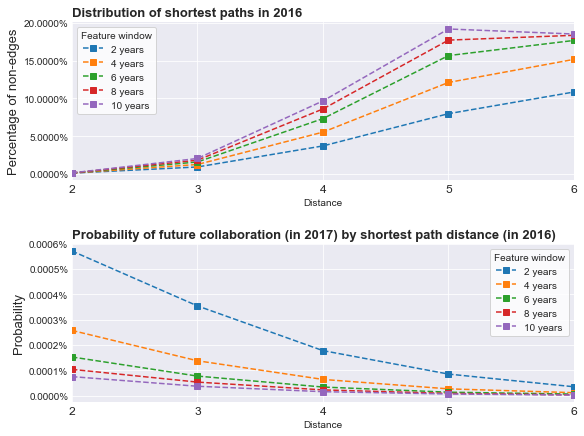

In [19]:
distances = df[['dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6']].apply(lambda x: x/df['non_edges']).T
links = df[['links_2', 'links_3', 'links_4', 'links_5', 'links_6']].apply(lambda x: x/df['non_edges']).T

f, ax = plt.subplots(2, 1, figsize=(9,7))

for i, var in enumerate([distances, links]):
    ax[i].plot(var[[2,4,6,8,10]], 's--')
    ax[i].set_xticklabels([2,3,4,5,6], size=12)
    ax[i].legend(['2 years', '4 years', '6 years', '8 years', '10 years'], title='Feature window', frameon=True, facecolor='w')
    ax[i].set_xlim(0,4)
    ax[i].set_xlabel('Distance')
    vals = ax[i].get_yticks()
    ax[i].set_yticklabels(['{:,.4%}'.format(x) for x in vals])
    
ax[0].set_title('Distribution of shortest paths in 2016', loc='left', size=13, weight='bold')
ax[1].set_title('Probability of future collaboration (in 2017) by shortest path distance (in 2016)', loc='left', size=13, weight='bold')

ax[0].set_ylabel('Percentage of non-edges', size=13)
ax[1].set_ylabel('Probability', size=13)
plt.subplots_adjust(hspace=0.4)

### 3.2 Feature extraction

Our features should be factors that may affect the probability of a future collaboration between two artists. We use a similar set of features to many other link prediction studies. For each pair of artists (i, j) that did not collaborate during a given feature window we use the function *get_data* to extract:

1. Degree i, j - the number of other artists with whom artist i/j collaborated

2. Volume i, j - the sum of the number of collaborations between artist i/j and each artist they collaborated with (i.e. weighted degree)

3. Preferential attachment - the degree of artist i multiplied by the degree of artist j (also known as 'rich get richer' mechanism; intended to capture any additional impact of both artists being prolific collaborators, compared to either artist individually being prolific)

4. Common neighbours - the number of artists with whom both artist i and artist j collaborated (a common neighbour may introduce two artists, and may indicate that the two artists move in similar circles)

5. Adamic-Adar index - a weighted measure of the number of common neighbours of artist i and artist j, where neighbours are given a weight which is the inverse of their degree (i.e. gives more weight to a common neighbour who has themselves collaborated with few people, who may be more likely to introduce the pair of artists than a neighbour who has collaborated with many other artists)

6. Jaccard coefficient - common neighbours divided by total neighbours of artist i and artist j (also known as 'intersection over union'; a number close to 1 would indicate near-complete overlap of the two artists' collaboration circles).

We restrict our attention to artists separated by 2 or 3 hops. Computing features for links of longer distances proved infeasible and, in any case, the probability of a link forming at such distances is very low as shown above. Features 4, 5 and 6 above all depend on two artists sharing at least one common neighbour. By definition, potential links of distance 3 imply zero common neighbours and so we can only compute features 1, 2 and 3. Some path-based features used in link prediction are defined over such distances but these proved too computationally expensive (e.g. we found that computing the number of shortest paths and Katz exponentially-damped path count, switches included in the code below, would have taken many weeks).

The image below demonstrates the calculation of features for a pair of artists who were separated by 1 hop in 2015 and who subsequently went on to collaborate in 2016. It shows the 1-hop neighbourhoods of the two artists over the period 2006 to 2015 (edge thickness represents edge weight i.e. the number of collaborations).

1. Degree i, degree j - 76, 53
2. Volume i, volume j - 346, 6,348
3. Preferential attachment - 76 * 53 = 4,028
4. Common neighbours = 8
5. Adamic-Adar index = 1/20 + 1/57 + 1/35 + 1/8 + 1/49 + 1/28 + 1/18 + 1/14 = 0.404
6. Jaccard coefficient = 8 / (76 + 53 - 8 - 1) = 0.067

<img src="https://github.com/nickconvery/link-prediction/raw/master/img/example_2.png" width='60%' align="left"></img>

In [20]:
def get_data(g_feat, g_label, dist, feat_window, end_year, shortest_path_count = False, katz = False, katz_dist = 5):
    
    data = list()
    visited = set()
    current = 0
    split = 0
    start=time.time()

    for node_a, node_a_dict in nx.all_pairs_shortest_path_length(g_feat, cutoff=dist):
        visited.add(node_a)

        for node_b, path_length in node_a_dict.items():
                
            if path_length == dist and node_b not in visited:

                deg_a = g_feat.degree(node_a, weight=None)
                deg_b = g_feat.degree(node_b, weight=None)
                vol_a = g_feat.degree(node_a, weight='weight')
                vol_b = g_feat.degree(node_b, weight='weight')
                pref_attach = deg_a * deg_b
                
                row = [deg_a, deg_b, vol_a, vol_b, pref_attach]
                
                if dist <= 2:

                    common_neighbors = len(list(nx.common_neighbors(g_feat, node_a, node_b)))
                    
                    for i, j, aa in adamic_adar_index(g_feat, [(node_a, node_b)]):
                        adamic_adar = aa
                        
                    for i, j, jac in jaccard_coefficient(g_feat, [(node_a, node_b)]):
                        jaccard = jac

                    row += [common_neighbors, adamic_adar, jaccard]

                if shortest_path_count:
                
                    shortest_path_count = 0
                    for path in nx.all_shortest_paths(g_feat, node_a, node_b):
                        shortest_path_count += 1
            
                    row += [shortest_path_count]

                if katz:
                    
                    katz_temp = list()
                    for path in nx.all_simple_paths(g_feat, node_a, node_b, cutoff=katz_dist):
                        katz_temp.append(len(path))
                    katz = list(Counter(katz_temp).values())

                    row += katz
                    
                label = int(g_label.has_edge(node_a, node_b))

                data.append(row + [label, node_a, node_b])
                
                current+=1                
                if current % 10000 == 0:
                    print(current, time.time() - start, row + [label, node_a, node_b])
                    
                if current % 16000000 == 0:
                    data = np.array(data)
                    save_obj(data, '{0}_fw_{1}_dist_{2}_{3}'.format(end_year, feat_window, dist, split))  
                    split += 1
                    del data
                    data = list()
    
    data = np.array(data)
    save_obj(data, '{0}_fw_{1}_dist_{2}_{3}'.format(end_year, feat_window, dist, split))                 

In [ ]:
ALIASES = load_obj('aliases')
MEMBERS = load_obj('members')
TRACKS = load_obj('tracks_2006to2017_unique')

TRAIN_END = 2016
TEST_END = TRAIN_END + 1
LABEL_WINDOW = 1
FEAT_WINDOWS = [1,2,3,4,5,6,7,8,9,10]
DISTANCES = [2,3]
VOCAL_CREDIT = r'(\bfeaturing|\bvocal|\brap)(?![^\[]*\])'

for w in FEAT_WINDOWS:
    
    for i in [TRAIN_END, TEST_END]:
        
        g_feat = make_graph(TRACKS, i-w, i-LABEL_WINDOW, VOCAL_CREDIT, ALIASES, MEMBERS)
        g_label = make_graph(TRACKS, i-w, i, VOCAL_CREDIT, ALIASES, MEMBERS)
        
        for d in DISTANCES:
            data = get_data(g_feat=g_feat, g_label=g_label, dist=d, feat_window=w, end_year=i)
            
        del g_feat, g_label

## 4. Analysis

In this section we present our analysis of the scraped and processed data. We begin by performing some exploratory analysis. We then discuss the classification algorithms used and our approach to evaluation, before presenting the results of the modelling.

Below we define two functions: one to load and concatenate the multi-part datasets, and the second to separate a dataset into features and labels.

In [21]:
def load_data(end_year, dist, feat_window, ids=True):
    
    cols = {2: ['degree_a', 'degree_b', 'volume_a', 'volume_b', 'preferential_attachment',
           'common_neighbours', 'adamic_adar', 'jaccard', 'label', 'artist_a', 'artist_b'],
        3: ['degree_a', 'degree_b', 'volume_a', 'volume_b', 'preferential_attachment',
           'label', 'artist_a', 'artist_b']}
    
    parts = glob.glob('{0}_fw_{1}_dist_{2}*.pkl'.format(end_year, feat_window, dist))
    data = list()
    
    for part in parts:
        with open(part, 'rb') as p:
            data.append(np.array(pickle.load(p)))
    
    data = np.vstack(data)
    
    if ids:
        data = pd.DataFrame(data, columns=cols[dist])
    else:
        data = pd.DataFrame(data[:, :-2], columns = cols[dist][:-2])
    
    return data

In [22]:
def features_and_labels(data, ids=True):
    
    data = data.values

    if ids:
        X = data[:, :-3]
        y = data[:, -3]
    else:
        X = data[:, :-1]
        y = data[:, -1]
        
    return X, y

### 4.1 Exploratory data analysis

We define a function that plots the distribution of each feature by class (positive or negative) for a given distance and feature window.

In [23]:
def plot_feat_distributions(dist, feat_window):
    
    df = load_data(2016, dist, feat_window)
    f, ax = plt.subplots(2,4, figsize=(16,8))
       
    if dist == 3:
        f.delaxes(ax[1][1])
        f.delaxes(ax[1][2])
        f.delaxes(ax[1][3])
    
    plt.subplots_adjust(hspace=0.3)
    plt.suptitle('Distance = {0}, Feature window = {1}: Feature distributions by label'.format(dist, feat_window), 
                 fontweight='bold', size=13)

    for i, col in enumerate(df.columns[:-3]):

        axlist = ax.flatten() 

        if col == 'common_neighbours':

            sns.distplot(df.loc[df.label == 0 ,col], kde=False, ax=axlist[i], label='Negative', norm_hist=True)
            sns.distplot(df.loc[df.label == 1 ,col], kde=False, ax=axlist[i], label='Positive', norm_hist=True)
            axlist[i].set_xlim(0,40)

        else:
            sns.distplot(np.log10(df.loc[df.label == 0 ,col]), kde=False, ax=axlist[i], label='Negative', norm_hist=True)
            sns.distplot(np.log10(df.loc[df.label == 1 ,col]), kde=False, ax=axlist[i], label='Positive', norm_hist=True)
            labs = [int(lab) for lab in axlist[i].get_xticks()]
            axlist[i].set_xticklabels(['$10^{%s}$' % lab for lab in labs], size=12)

        axlist[i].set_yticklabels([])
        axlist[i].set_title(col, loc='left')
        axlist[i].set_xlabel('')
        axlist[i].legend(frameon=True, facecolor='w')

The figure below shows the distribution of each feature for pairs of artists separated by 2 hops for a feature window of 10 years (2006 to 2015), depending on whether the pair went on to collaborate in 2016 (the training dataset).

All features appear to have at least some power in discriminating between the positive and negative class, as indicated by distributions which are all shifted to the right for the positive class. Pairs of previously unconnected artists that go on to collaborate tend to be more prolific collaborators (as indicated by the top row of features), and have higher scores for preferential attachment, common neighbours, Adamic-Adar index and Jaccard coefficient.

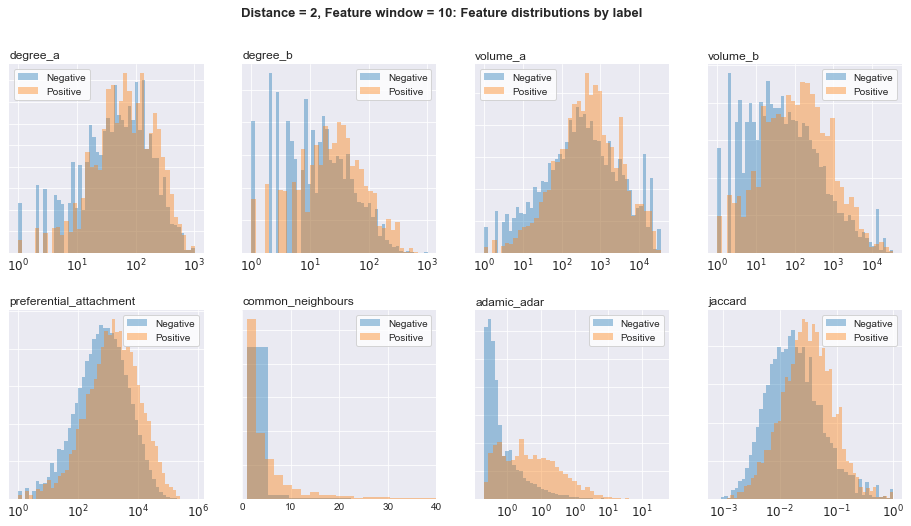

In [24]:
plot_feat_distributions(2,10)

The figure below shows the distribution of each feature for pairs of artists separated by 3 hops for a feature window of 10 years (2006 to 2015), depending on whether the pair went on to collaborate in 2016 (the training dataset). Similar to above, the distributions appear to be shifted to the right across all features for the positive class relative to the negative class.

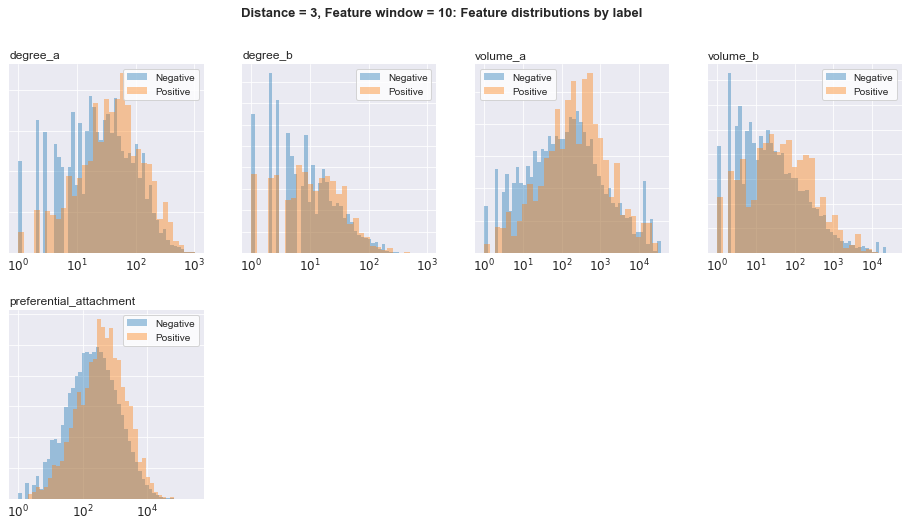

In [25]:
plot_feat_distributions(3,10)

In the charts above we considered only a single feature window of 10 years. The two tables below show how the median of each feature varies for potential links of distance 2 (first table) and distance 3 (second table) as the feature window ranges from 1 to 10 years. For potential links of both distance 2 and 3, the node-specific features (degree, volume and preferential attachement) all increase with the feature window as this captures a greater number of collaborations. For potential links of distance 2, the median of the Adamic-Adar index and Jaccard coefficient decreases with the feature window, while the median of common neighbours remains unchanged.

In [26]:
def medians_by_feat_window(dist, feat_windows):
    med = list()
    for w in feat_windows:
        data = load_data(2016,dist,w)
        med.append(data.describe().T.iloc[:-3, 5])
    return pd.concat(med, axis=1, keys=[('Distance = {0}: Medians by feature window (years)'.format(dist), y) for y in feat_windows])

In [27]:
feat_windows = [1,2,3,4,5,6,7,8,9,10]
medians_by_feat_window(2, feat_windows)

Distance = 2: Medians by feature window (years)  \
                                                                     1    
degree_a                                                          15.00   
degree_b                                                           8.00   
volume_a                                                          42.00   
volume_b                                                          16.00   
preferential_attachment                                          108.00   
common_neighbours                                                  1.00   
adamic_adar                                                        0.30   
jaccard                                                            0.05   

                                                                          \
                            2      3      4      5      6      7      8    
degree_a                 23.00  28.00  32.00  33.00  37.00  39.00  42.00   
degree_b                 10.00  11.00  11.00  12.00  13.00  13.00  13.00   
volume_a                 80.00 113.00 137.00 149.00 179.00 199.00 238.00   
volume_b                 23.00  28.00  29.00  29.00  32.00  34.00  37.00   
preferential_attachment 208.00 288.00 324.00 378.00 430.00 476.00 527.00   
common_neighbours         1.00   1.00   1.00   1.00   1.00   1.00   1.00   
adamic_adar               0.27   0.25   0.24   0.23   0.23   0.22   0.22   
jaccard                   0.03   0.03   0.03   0.02   0.02   0.02   0.02   

                                       
                            9      10  
degree_a                 46.00  51.00  
degree_b                 14.00  14.00  
volume_a                279.00 344.00  
volume_b                 40.00  43.00  
preferential_attachment 606.00 687.00  
common_neighbours         1.00   1.00  
adamic_adar               0.22   0.21  
jaccard                   0.02   0.02

In [28]:
medians_by_feat_window(3, feat_windows)

Distance = 3: Medians by feature window (years)  \
                                                                     1    
degree_a                                                          13.00   
degree_b                                                           7.00   
volume_a                                                          35.00   
volume_b                                                          15.00   
preferential_attachment                                           84.00   

                                                                          \
                            2      3      4      5      6      7      8    
degree_a                 17.00  19.00  20.00  21.00  22.00  23.00  23.00   
degree_b                  7.00   8.00   8.00   8.00   8.00   8.00   8.00   
volume_a                 55.00  68.00  77.00  82.00  90.00  96.00 104.00   
volume_b                 18.00  19.00  18.00  19.00  19.00  20.00  20.00   
preferential_attachment 120.00 140.00 150.00 162.00 172.00 180.00 185.00   

                                       
                            9      10  
degree_a                 25.00  25.00  
degree_b                  8.00   8.00  
volume_a                117.00 131.00  
volume_b                 20.00  20.00  
preferential_attachment 198.00 207.00

### 4.2 Classifiers

In the first instance we will consider the default scikit-learn implementations of two supervised learning algorithms that are suitable for binary classification problems: logistic regression and decision tree. 

The scikit-learn implementation of logistic regression uses regularisation which helps to avoid overfitting by constraining in some way the parameters to be learned during training (depending on the form of regularisation this may be to set a parameter to zero if possible, or to try and keep parameters small). We will therefore scale each feature using standardisation (subtracting the mean and dividing by the standard deviation) as regularisation is sensitive to the scale of features. This concern is not relevant to decision trees, although for simplicity we will use the standardised data (standardisation is a monotonic transformation in that it preserves ordering so will not affect the learned tree beyond scaling the values used at its nodes).

We define a function *fit_models* which takes an instance of a classifier and lists of distances and feature windows as inputs, trains that classifier for each distance and feature window, and returns a dictionary of predicted probablities for the test set links for each distance and feature window.

In [29]:
def fit_models(classifier, dists, feat_windows):
    
    probs = {d: {w: [] for w in feat_windows} for d in dists}
    
    for d, windows in probs.items():
    
        for w, model in windows.items():

            train = load_data(2016, d, w, ids=False)
            X_train, y_train = features_and_labels(train, ids=False)
            del train

            test = load_data(2017, d, w, ids=False)
            X_test, y_test = features_and_labels(test, ids=False)
            del test
    
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            classifier.fit(X_train, y_train)    
            
            probs[d][w] = classifier.predict_proba(X_test)[:, 1]
            
    return probs

### 4.3 Evaluation strategy

We earlier set out two objectives:

1. Assess the extent to which it is possible to outperform a baseline random predictor in predicting future collaborations between hip hop artists. We selected random as a baseline due to the class imbalance encountered in this problem (as shown above, positive:negative class ratio is in the region of 1:10,000 for potential links of distance 2 depending on the feature window and worse still for distance 3) The implication of this is that an 'always no' predictor would achieve around 99.9999% accuracy.

2. Assess the impact of the feature window on classifier performance. Our intuition is that performance will at first increase due to increased information but perhaps eventually begin to decrease due to noise as the feature window extends. For instance, if w=1 this could miss a common neighbour that two artists shared from collaborations during t-2. However, if w=30 two artists may share a common neighbour that is long since inactive and so unlikely to introduce the pair.

We will assess objective 1 using both Receiver Operating Characteristic (ROC) curves and precision-recall curves. 

ROC curves plot the true positive rate against the false positive rate as the decision threshold for which a classifier assigns an example with a given predicted probability of belonging to the positive class is changed. The true positive rate is the proportion of all positive testing examples that the classifier classified as positive. The false positive rate is the proportion of negative testing examples that the classifier misclassified as positive. A random predictor (i.e. one that assigned a random probability that an instance belonged to the positive class) would have expected true and false positive rates equal to the decision threshold (e.g. with a decision threshold of 0.5 a random predictor would have expected true and false positive rates of 50%).

Precision-recall curves plot precision against recall as the decision threshold is changed. Precision is the proportion of all testing examples that the classifier classified as positive which were actually positive. Recall is another term for the true positive rate. A random predictor would have expected precision equal to the class imbalance ratio.

We will assess objective 2 using ROC because ROC does not depend on the degree of class imbalance which, as shown above, increases with the feature window. That is, for ROC, the true positive rate depends only on the number of positive examples and the false positive rate depends only on the number of negative examples. Precision on the other hand will depend on the class imbalance of the testing data and so will not be appropriate to compare performance across feature windows. That is, for a classifier with a given true and false positive rate, if there are relatively more negative examples in the testing dataset then precision will be lower.

Below we define a number of functions which take the predicted probabilities of a classifer for the testing set as input and produce various evaluation metrics and plots.

In [30]:
def get_auc_roc(probs, dist, feat_window):
    
    test = load_data(2017, dist, feat_window)
    X_test, y_test = features_and_labels(test)
    del X_test, test
    
    fpr, tpr, thresholds = roc_curve(y_test, probs[dist][feat_window])
    auc_roc = auc(fpr, tpr)
    
    return auc_roc

In [31]:
def plot_roc(probs, dist, feat_window, ax, label):
    
    ax.plot([0,1], [0,1], linestyle='--')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    prob = probs[dist][feat_window]
    test = load_data(2017, dist, feat_window)
    X_test, y_test = features_and_labels(test)
    del X_test, test
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    ax.plot(fpr, tpr, label=label)

    ax.set_xlabel('False positive rate', size=12)
    ax.set_ylabel('True positive rate', size=12)
    y_vals = ax.get_yticks()
    x_vals = ax.get_xticks()
    ax.set_yticklabels(['{:.0%}'.format(y) for y in y_vals], size=12)
    ax.set_xticklabels(['{:.0%}'.format(x) for x in x_vals], size=12)      

In [32]:
def plot_pr(probs, dist, feat_window, ax, label):
    
    prob = probs[dist][feat_window]
    test = load_data(2017, dist, feat_window)
    X_test, y_test = features_and_labels(test)
    del X_test, test
    
    precision, recall, thresholds = precision_recall_curve(y_test, prob)
    ax.plot(recall, np.log10(precision), label=label)
    
    ax.set_xlabel('Recall', size=12)
    ax.set_ylabel('Precision', size=12)
    
    y_vals = ax.get_yticks()
    x_vals = ax.get_xticks()
    ax.set_yticklabels(['$10^{%s}$%%' % y for y in y_vals], size=12)
    ax.set_xticklabels(['{:.0%}'.format(x) for x in x_vals], size=12)

In [33]:
def get_top_k_precision(probs, dist, feat_window, k):
    
    prob = probs[dist][feat_window]
    test = load_data(2017, dist, feat_window)
    X_test, y_test = features_and_labels(test)
    del test, X_test
    combined = np.vstack((y_test, prob)).T
    sorted_ = combined[combined[:,1].argsort()][::-1]
    top_k_precision = np.sum(sorted_[:k, 0])/k
    
    return top_k_precision

In [34]:
def plot_top_k_precision(probs, dist, feat_window, ax, label):
    
    top_k_precision = list()
    klist = [10**i for i in range(1,7)]
    for k in klist:
        top_k_precision.append(get_top_k_precision(probs, dist, feat_window, k))

    ax.plot(np.log10(klist), top_k_precision, 's--', label=label)
    ax.set_xlim(1,6)
    
    ax.set_xlabel('K', size=12)
    ax.set_ylabel('Precision', size=12)
    
    y_vals = ax.get_yticks()
    x_vals = [int(x) for x in ax.get_xticks()]
    ax.set_yticklabels(['{0:.2%}'.format(y) for y in y_vals], size=12)
    ax.set_xticklabels(['$10^{%s}$' % x for x in x_vals], size=12)

### 4.4 Results

#### 4.4.1 Logistic regression and decision tree

We first train a logistic regression and decision tree classifier for each combinatoin of feature window and distance. 

All hyperparameters are scikit-learn defaults. This is with the exception of max_depth for the decision tree which is arbitrarily set at 5. Preliminary investigation showed that the default of None led to severe overfitting. At this stage, the selection of a max_depth of 5 is arbitrary and we will later investigate the impact of changing this parameter (among others) on classifier performance.

In [ ]:
dists = [2,3]
feat_windows = [1,2,3,4,5,6,7,8,9,10]

logistic_regression = fit_models(LogisticRegression, dists, feat_windows)
decision_tree = fit_models(DecisionTreeClassifier(max_depth=5), dists, feat_windows)

save_obj(logistic_regression, 'logistic_regression')
save_obj(decision_tree, 'decision_tree')

In [35]:
logistic_regression = load_obj('logistic_regression')
decision_tree = load_obj('decision_tree')

The plot below shows the Area Under the ROC (AUROC) curve achieved by the two classifiers for links of distance 2 and 3 across feature windows from 1 to 10 years. AUROC can be interpreted as the probability that a classifier ranks a randomly selected positive example above a randomly selected negative example (in terms of predicted probability). A random predictor has an expected AUROC of 0.5.

In relation to our first objective, all AUROCs are in excess of 0.5 which indicates that it is possible to outperform a baseline random predictor in predicting future collaborations between hip hop artists. This outperformance is significantly higher when considering future collaborations between artists separated by 2 hops rather than 3 hops. As discussed above, we are able to compute more features for pairs separated by 2 hops. Indeed, at 3 hops, the features are completely node-specific and do not measure proximity between the artists in any way.

In relation to our second objective, we observe that performance when predicting future collaborations between artists separated by 2 hops increases with the feature window at all steps (except logistic regression with a feature window of 8). However, there is evidence of diminishing returns to considering longer feature windows as the incremental improvements in AUROC are very small (0.5-1pp) beyond a feature window of 7 years.

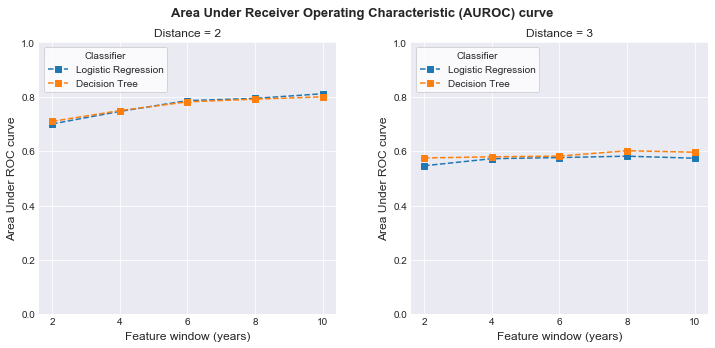

In [36]:
dists = [2,3]
feat_windows = [2,4,6,8,10]

f, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_title('Distance = 2')
ax[1].set_title('Distance = 3')
plt.subplots_adjust(wspace=0.25)
plt.suptitle('Area Under Receiver Operating Characteristic (AUROC) curve', fontweight='bold', size=13)

for i, d in enumerate(dists):
    for name, probs in {'Logistic Regression': logistic_regression, 'Decision Tree': decision_tree}.items():
        auc_rocs=list()
        for w in feat_windows:
            auc_rocs.append(get_auc_roc(probs, d, w))
        ax[i].plot(feat_windows, auc_rocs, 's--', label=name)
     
    ax[i].legend(title='Classifier', frameon=True, facecolor='w', loc='upper left')
    ax[i].set_xticks(feat_windows)
    ax[i].set_xlabel('Feature window (years)', size=12)
    ax[i].set_ylabel('Area Under ROC curve', size=12)
    ax[i].set_ylim(0,1)

Below we plot the ROC curves for logistic regression and decision tree for potential links of distance 2 across various feature windows. Although the two classifiers achieved similar AUROCs as shown above, there are subtle difference in their performance at different decision thresholds which can be seen by considering the underlying ROC curves. 

For higher decision thresholds (i.e. closer to 1, in the bottom left of the ROC plots) logistic regression outperforms the decision tree with a higher true positive rate for any given false positive rate. However, for lower decision thresholds (i.e. closer to zero, in the top right of the ROC plots) this is reversed.

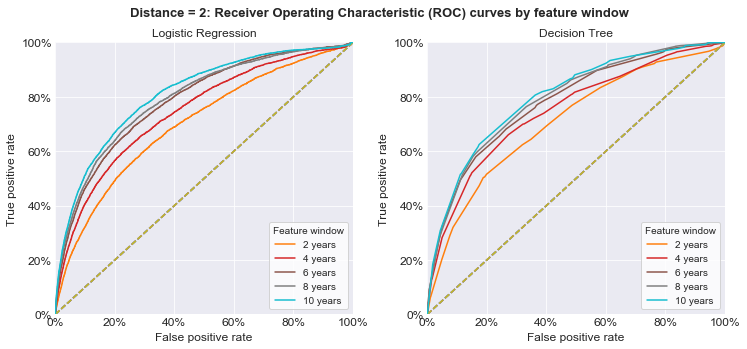

In [37]:
f, ax = plt.subplots(1,2, figsize=(12,5))
plt.subplots_adjust(wspace=0.25)
plt.suptitle('Distance = 2: Receiver Operating Characteristic (ROC) curves by feature window', fontweight='bold', size=13)
ax[0].set_title('Logistic Regression')
ax[1].set_title('Decision Tree')

for w in [2,4,6,8,10]:
    plot_roc(logistic_regression, 2, w, ax[0], '{0} years'.format(w))
    plot_roc(decision_tree, 2, w, ax[1], '{0} years'.format(w))

ax[0].legend(title='Feature window', loc='lower right', frameon=True, facecolor='w')
ax[1].legend(title='Feature window', loc='lower right', frameon=True, facecolor='w');

We observe similar behaviour for the ROC curves for distance 3, where the performance of logistic regression is actually worse than random for lower decision thresholds.

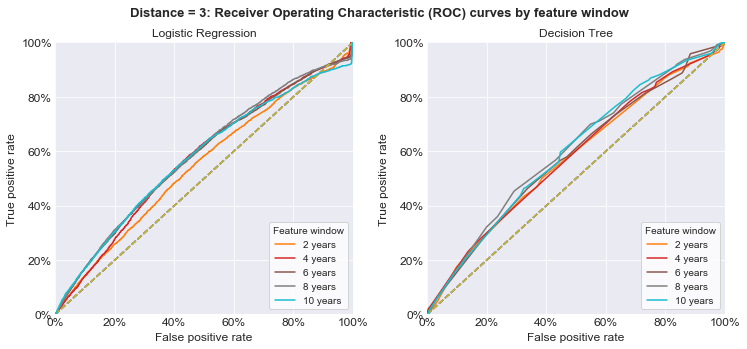

In [38]:
f, ax = plt.subplots(1,2, figsize=(12,5))
plt.subplots_adjust(wspace=0.25)
plt.suptitle('Distance = 3: Receiver Operating Characteristic (ROC) curves by feature window', fontweight='bold', size=13)
ax[0].set_title('Logistic Regression')
ax[1].set_title('Decision Tree')

for w in [2,4,6,8,10]:
    plot_roc(logistic_regression, 3, w, ax[0], '{0} years'.format(w))
    plot_roc(decision_tree, 3, w, ax[1], '{0} years'.format(w))

ax[0].legend(title='Feature window', loc='lower right', frameon=True, facecolor='w')
ax[1].legend(title='Feature window', loc='lower right', frameon=True, facecolor='w');

We have not been able to establish the 'optimal' feature window as performance appears to increase (though at a decreasing rate) over the range of feature windows considered. For the remainder of this notebook, we will consider peformance for the longest feature window of 10 years.

The plots below show precision-recall curves for potential links at distance 2 and 3. This presents a much more sober view of performance than ROC which now accounts for the degree of class imbalance and demonstrates the difficulty of the link prediction task. Achieveable precision appears to be in the range of 0.01% to 0.1% for potential links of distance 2, and 0.003% (which is (10^-3.5)%) for potential links of distance 3, depending on the decision threshold. This is orders of magnitude higher than a baseline random predictor as shown below. However, in absolute terms this is not a level of precision that would be acceptable for deploying an application that suggests artists with whom an artist should collaborate.

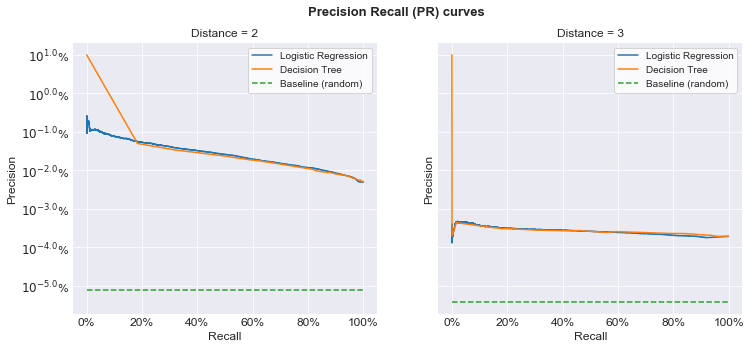

In [39]:
f, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
plt.suptitle('Precision Recall (PR) curves', fontweight='bold', size=13)
ax[0].set_title('Distance = 2')
ax[1].set_title('Distance = 3')

plot_pr(logistic_regression, 2, 10, ax[0], 'Logistic Regression')
plot_pr(decision_tree, 2, 10, ax[0], 'Decision Tree')
plot_pr(logistic_regression, 3, 10, ax[1], 'Logistic Regression')
plot_pr(decision_tree, 3, 10, ax[1], 'Decision Tree')

ax[0].plot([0,1], np.log10([links.loc['links_2'][10],links.loc['links_2'][10]]), '--', label='Baseline (random)')
ax[1].plot([0,1], np.log10([links.loc['links_3'][10],links.loc['links_3'][10]]), '--', label='Baseline (random)')

ax[0].legend(frameon=True, facecolor='w')
ax[1].legend(frameon=True, facecolor='w');

Finally, to consider an alternative metric, we plot the precision for the top-K highest scores output by each classifier (again for a feature window of 10 years). For potential links of distance 2, logistic regression outperforms the decision tree which reflects the trend we observed in the ROC curves above (higer performance for higher decision thresholds).

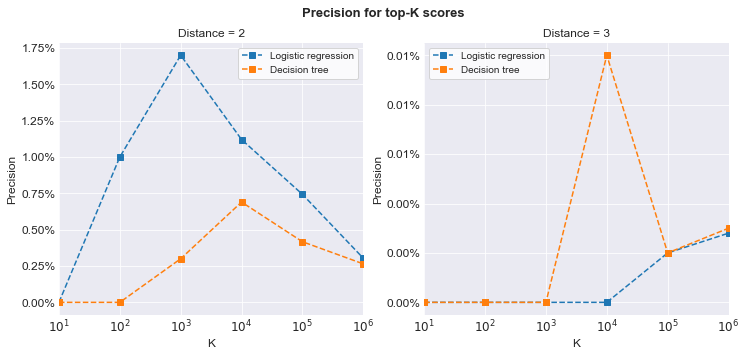

In [40]:
f, ax = plt.subplots(1, 2, figsize=(12,5))
plt.suptitle('Precision for top-K scores', fontweight='bold', size=13)
ax[0].set_title('Distance = 2')
ax[1].set_title('Distance = 3')

plot_top_k_precision(logistic_regression, 2, 10, ax[0], 'Logistic regression')
plot_top_k_precision(decision_tree, 2, 10, ax[0], 'Decision tree')
plot_top_k_precision(logistic_regression, 3, 10, ax[1], 'Logistic regression')
plot_top_k_precision(decision_tree, 3, 10, ax[1], 'Decision tree')

ax[0].legend(frameon=True, facecolor='w')
ax[1].legend(frameon=True, facecolor='w');

#### 4.4.2 Ensemble methods

In this section we briefly consider the extent to which the ensemble method of bagging can be used to boost performance. Bagging refers to the process of training multiple classifiers on random samples of the training dataset with replacement, and then predicting the class of a new example by way of a majority vote across these classifiers.

Because we are dealing with extreme class imbalance, we use the BalancedBaggingClassifier implementation from the *imblearn* library which performs random undersampling to balance from the negative class. Pure random sampling would have a high probability of resulting in a dataset with very few (or none) of the positive class. As above, we do not however perform any test set sampling.

We find that the impact on the performance of logisitic regression is almost imperceptible, while the decision tree achieves marginally higher performance as measured by AUROC (approx 1.5pp).

In [41]:
lr_bagged = fit_models(BalancedBaggingClassifier(base_estimator=LogisticRegression()), [2], [10])
dt_bagged = fit_models(BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5)), [2], [10])

In [42]:
print('Area Under Receiver Operating Characteristic curve for distance = 2, feature window = 10:')

print('Logistic regression: {0:.2%}, Bagged logistic regression: {1:.2%}'.format(get_auc_roc(logistic_regression, 2, 10), 
                                                                         get_auc_roc(lr_bagged, 2, 10)))

print('Decision tree: {0:.2%}, Bagged decision trees: {1:.2%}'.format(get_auc_roc(decision_tree, 2, 10), 
                                                                         get_auc_roc(dt_bagged, 2, 10)))

Area Under Receiver Operating Characteristic curve for distance = 2, feature window = 10:
Logistic regression: 81.13%, Bagged logistic regression: 81.05%
Decision tree: 79.99%, Bagged decision trees: 81.51%


#### 4.4.3 Hyperparameter tuning

Finally, we consider the extent to which a (limited) grid search of a subset of the hyperparameters for the logistic regression and decision tree classifiers can be used to boost performance. 

For logistic regression, we vary the regularisation constant and the method of regularisation (l1 - lasso or l2 - ridge). For decision tree, we vary the criteria used to measure the impurity of a split (gini, entropy) and the maximum depth of the tree (i.e. the maximum number of splits before any leaf).

For both logistic regression and decision tree, we find that the best set of paramaters as measured by AUROC leads to only a marginal increase in performance.

In [43]:
param_grid_lr = {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["l1","l2"]}
param_grid_dt = {"max_depth": [None, 3, 5, 10, 20], 'criterion': ['gini', 'entropy']}

In [44]:
def tune_bagged_model(base_estimator, dist, feat_window, param_grid):
    
    best_auroc = 0
    best_params = dict()

    for params in ParameterGrid(param_grid):
        model = fit_models(BalancedBaggingClassifier(base_estimator=base_estimator(**params)), [2], [10])
        auroc = get_auc_roc(model, dist, feat_window)
        print(params, auroc)
    
        if auroc > best_auroc:
            best_auroc = auroc
            best_params = params
        
    return model, best_auroc, best_params

In [45]:
best_model_lr, best_auroc_lr, best_params_lr = tune_bagged_model(LogisticRegression, 2, 10, param_grid_lr)
best_model_dt, best_auroc_dt, best_params_dt = tune_bagged_model(DecisionTreeClassifier, 2, 10, param_grid_dt)

print('Area Under Receiver Operating Characteristic curve for distance = 2, feature window = 10:')

print('Bagged logistic regression: {0:.2%}, Bagged logistic regression (tuned): {1:.2%}'.format(get_auc_roc(lr_bagged, 2, 10), 
                                                                         best_auroc_lr))

print('Bagged decision trees: {0:.2%}, Bagged decision trees (tuned): {1:.2%}'.format(get_auc_roc(dt_bagged, 2, 10), 
                                                                         best_auroc_dt))

{'C': 0.01, 'penalty': 'l1'} 0.8079465342035702
{'C': 0.01, 'penalty': 'l2'} 0.803060067800456
{'C': 0.1, 'penalty': 'l1'} 0.8114120026234551
{'C': 0.1, 'penalty': 'l2'} 0.8106296066774036
{'C': 1, 'penalty': 'l1'} 0.8108995185540042
{'C': 1, 'penalty': 'l2'} 0.8116223143858591
{'C': 10, 'penalty': 'l1'} 0.8109566153497886
{'C': 10, 'penalty': 'l2'} 0.8109467130146775
{'C': 100, 'penalty': 'l1'} 0.8109675655959745
{'C': 100, 'penalty': 'l2'} 0.811305854335046
{'criterion': 'gini', 'max_depth': None} 0.784721139540089
{'criterion': 'gini', 'max_depth': 3} 0.80570174091182
{'criterion': 'gini', 'max_depth': 5} 0.8180070662644069
{'criterion': 'gini', 'max_depth': 10} 0.815860244275842
{'criterion': 'gini', 'max_depth': 20} 0.7916793693820394
{'criterion': 'entropy', 'max_depth': None} 0.7852029834324308
{'criterion': 'entropy', 'max_depth': 3} 0.8055948262004802
{'criterion': 'entropy', 'max_depth': 5} 0.814272141880559
{'criterion': 'entropy', 'max_depth': 10} 0.814287124875778
{'criter

## 5. Findings and reflections

### 5.1 Objective 1: Ability to outperform a baseline random classifier

In relation to our first objective, we found that it is indeed possible to outperform a baseline random predictor in predicting future collaborations between hip hop artists (using features extracted from the network formed by prior collaborations). 

As described above, we divided the link prediction task into subproblems based on the shortest path between potential links. In other words, we considered pairs of artists separated by two hops separately from pairs of artists separated by three hops. Due to computational feasibility we did not consider pairs of artists separated by four or more hops. Our statement regarding the ability to in general outpredict a baseline random classifier is therefore limited to pairs of artists separated by 2 or 3 hops. 

It is possible that this claim does not hold at greater distances. Indeed, one can imagine that the reasons for which a pair of artists separated by many hops go on to collaborate in a future period (which we found to be extremely unlikely in the first place) might actually be better captured by a random process than by anything inherent to the prior topology of the network (e.g. a chance encounter).

### 5.2 Objective 2: Impact of feature window on predicting future collaborations

Our second objective was to assess the impact of varying the duration of the feature window on the ability of a classifier to predict future collaborations between hip hop artists. We decided that ROC would be the appropriate evaluation metric as precision depends on class imbalance, which is more extreme for longer feature windows.

We hypothesised that classifier performance may at first increase due to increased information but perhaps eventually begin to decrease due to noise. For instance, if w=1 this could miss a common neighbour that two artists shared from collaborations during t-2. However, if w=30 two artists may share a common neighbour that is long since inactive and so unlikely to introduce the pair.

For pairs of artists separated by 2 hops, the performance of logistic regression and decision tree classifiers of predicting future collaborations as measured by AUROC increased at all steps as the feature window was extended from one year to ten years (with the sole exception of logistic regression at eight years). However, there is evidence of diminishing returns to considering longer feature windows as the incremental improvements in AUROC are small (0.5-1pp) beyond a feature window of seven years. Based on this data, we are unable to test our hypothesis and determine a ‘global’ optimal feature window.

For pairs of artists separated by 3 hops, the performance of logistic regression and decision tree classifiers appeared to randomly fluctuate between 0.55 and 0.60 regardless of the feature window. This is because we were able to compute fewer features for artists separated by three hops, namely only the degree and weighted degree of each artist and the product of their degrees (measures based on common neighbours are not defined by definition, and path-based measures of proximity proved too expensive to compute). These are all node-specific features which do not depend on the topology of the network. We would therefore not expect performance to vary with the feature window, as the notion of capturing more information about potential mechanisms by which a future collaboration may occur (e.g. via a common neighbour) does not apply to these features.


### 5.3 Uses and limitations

A practical motivation for our analysis was that an algorithm that was sufficiently ‘good’ at predicting future collaborations could be used by artists to proactively identify other artists with whom they are likely to collaborate in the future and thereby accelerate the collaborative process. 

For instance, suppose two artists collaborate next year, t+1, because they get introduced by a mutual friend in that year. The basis for our analysis is that, in principle, a supervised learning algorithm can learn from a set of training data a function that reflects such mechanisms of link formation by mapping artists with common neighbours to a high likelihood of collaborating. Given a new pair of artists the algorithm could identify that a collaboration is highly likely to occur in the next year due to the fact that the artists have a mutual friend. This would enable the collaboration to occur in the current year, t, prior to when the mutual friend would otherwise have introduced the two artists.

We found that achieveable levels of precision are several orders of magnitude higher than a random classifier. However, because we are dealing with extreme class imbalance, this still equates to intolerably low absolute levels of precision (in the range of 0.01% to 0.1% for artists separated by two hops, and 0.003% for artists separated by three hops). With precision of 0.1%, only 1 in 1000 recommendations would represent people that an artist would otherwise have gone on to collaborate with. We therefore do not consider that these algorithms would be suitable for use by artists to proactively identify other artists with whom to collaborate. 

### 5.4 Future work

We briefly experimented with bagging and hyperparameter tuning which yielded only marginal increases in performance. We consider future efforts would be best focussed on including more features. For instance, future work could try to scrape data on node attributes such as the country in which an artist resides or the sub-genres in which they operate, and then check for overlap, in order to better distinguish between positive and negative examples. Given more computational power and time, path-based measures of proximity could also be computed. In addition, as discussed above, longer feature windows could be analysed.

## 6. References

M. Al Hasan, V. Chaoji, S. Salem, and M. Zaki. Link prediction using supervised learning. In Workshop on Link Discovery: Issues, Approaches and Apps., 2005. https://archive.siam.org/meetings/sdm06/workproceed/Link%20Analysis/12.pdf

Yang, Y., Lichtenwalter, R.N. & Chawla, N.V. Knowl Inf Syst (2015) 45: 751. https://doi.org/10.1007/s10115-014-0789-0 